In [1]:
#General imports
import copy
import gensim
import gensim.downloader as gloader
import matplotlib.pyplot as plt
import numpy as np  
import os  
import pandas as pd  
import re
import seaborn as sb
import sys 
from tqdm import tqdm
from typing import Iterable, List, Dict, Tuple, Set
import urllib.request  
import zipfile  

#sklearn and tensorflow imports
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, GRU, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

In [2]:
#fixed seeds to get reproducible results
np.random.seed(42)
set_seed(42)

#Bulding the dataframe

## Dataset download and extraction

In [3]:
DATASET_NAME = "dataset.zip"
DATASET_FOLDERNAME = "Dataset"
DATASET_SUBFOLDER = "dependency_treebank/"
SPLIT_DISTRIBUTION = [100, 150, 199]  #indeces to split in train, validation and test. 

working_folder = os.getcwd()

print("Current working directory: " + str(working_folder))

dataset_folder = os.path.join(os.getcwd(), DATASET_FOLDERNAME)

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dataset.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)
    print("Successful extraction")

dataset_folder = os.path.join(dataset_folder, DATASET_SUBFOLDER)

Current working directory: /content
Successful download
Successful extraction


In [4]:
print(dataset_folder)

/content/Dataset/dependency_treebank/


## Dataframe construction

In [5]:
def encode_dataset(dataset_folder: str, 
                   split_dist: list(), ) -> Dict[str,pd.DataFrame]:
    """
    Encode the dataset into three dataframes, returned in a dict.

    :param 
        - dataset_folder: folder of the extracted dataset
        - split_dist: list of indeces to be used to split in train, validation and test

    :return
        - df_dict: dictionary of train, validation and test dataframes
    """
    
    #dictionary of dataframes to return
    df_dict = {"train": pd.DataFrame(columns=['sentence', 'labels']),
                "val": pd.DataFrame(columns=['sentence', 'labels']),
                "test":pd.DataFrame(columns=['sentence', 'labels'])}
    split = ""

    for filename in sorted(os.listdir(dataset_folder)): #files are read following the order
        file_path = os.path.join(dataset_folder, filename)
        try:
            if os.path.isfile(file_path):
                with open(file_path, mode='r', encoding='utf-8') as text_file:
                    # read it and extract 
                    document_number = filename.split("_")[1].split(".")[0]

                    if int(document_number) <= split_dist[0]:  #find the split the file belongs to
                        split = "train"
                    elif split_dist[0] < int(document_number) <= split_dist[1]:
                        split = "val"
                    else:
                        split = "test"

                    df_file = pd.read_table(
                        file_path, 
                        delimiter='\t', 
                        names=['word', 'label'], 
                        usecols=[0,1],
                        skip_blank_lines=False)
                    
                    #splitting file content in sentences
                    idx = list(df_file.loc[df_file.isnull()['word']].index) #sentences are divided by a blank line, interpreted as a null value. 
                    idx.append(len(df_file))
                    prev = 0
                    for sep in idx:    #to split in sentences, word are read from idx "prev" to "sep", which is why we add len(df_file) to the list of indeces
                        df_sentence = pd.DataFrame({
                            'sentence': [df_file['word'][prev:sep].to_list()],  #sentence column contains the list of words forming the sentence 
                            'labels': [df_file['label'][prev:sep].to_list()]})  #labels column contains the list of labels associated with the words forming the sentence 
                        df_dict[split] = pd.concat([df_dict[split], df_sentence], ignore_index=True)  #adding the row to the appropriate dataframe (according to the split)
                        prev = sep + 1
                    
        except Exception as e:
            print('Failed to process %s. Reason: %s' % (file_path, e))
            sys.exit(0)

    return df_dict

In [6]:
df_dict = encode_dataset(dataset_folder, SPLIT_DISTRIBUTION)

In [7]:
df_dict["train"].head()

,sentence,labels
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


In [8]:
df_dict["val"].head()

,sentence,labels
0,"[A, House-Senate, conference, approved, major,...","[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ..."
1,"[For, the, Agency, for, International, Develop...","[IN, DT, NNP, IN, NNP, NNP, ,, NNS, VBD, $, CD..."
2,"[The, conference, approved, at, least, $, 55, ...","[DT, NN, VBD, IN, JJS, $, CD, CD, IN, JJ, NN, ..."
3,"[The, agreement, on, Poland, contrasts, with, ...","[DT, NN, IN, NNP, VBZ, IN, DT, JJ, NNS, VBG, I..."
4,"[These, fiscal, pressures, are, also, a, facto...","[DT, JJ, NNS, VBP, RB, DT, NN, IN, VBG, DT, NN..."


In [9]:
df_dict["test"].head()

,sentence,labels
0,"[Intelogic, Trace, Inc., ,, San, Antonio, ,, T...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
1,"[The, move, boosts, Intelogic, Chairman, Asher...","[DT, NN, VBZ, NNP, NNP, NNP, NNP, POS, NN, TO,..."
2,"[Mr., Ackerman, already, is, seeking, to, oust...","[NNP, NNP, RB, VBZ, VBG, TO, VB, NNP, NNP, IN,..."
3,"[The, action, followed, by, one, day, an, Inte...","[DT, NN, VBN, IN, CD, NN, DT, NNP, NN, IN, PRP..."
4,"[In, New, York, Stock, Exchange, composite, tr...","[IN, NNP, NNP, NNP, NNP, JJ, NN, NN, ,, NNP, N..."


In [10]:
#Creating x and y starting from dataframe just built

x = {"train": df_dict['train']['sentence'],
     "val": df_dict['val']['sentence'],
     "test": df_dict['test']['sentence']}

y = {"train": df_dict['train']['labels'],
     "val": df_dict['val']['labels'],
     "test": df_dict['test']['labels']}

# Glove Embedding model, vocabulary and OOV detection

## Load Glove embedding

We will start using embedding_dimension=50 to speed up the process. Anyway, at the end of this notebook we will move to embedding_dimension=300 to improve results

In [11]:
def load_GloVe_embedding(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [12]:
EMBEDDING_DIMENSION = 50
glove_emb_model = load_GloVe_embedding(EMBEDDING_DIMENSION)

[==================================================] 100.0% 66.0/66.0MB downloaded


##Creating initial vocabulary

In [13]:
from collections import OrderedDict

def build_vocabulary(sr: pd.Series) -> List[str]:
    """
    Given a series of sentences, so a series of list of words, builds the corresponding vocabulary.

    :param sr: series of sentences, so a a series of list of words (pandas.Series)
    :return:
      - vocabulary: set of unique terms that build up the vocabulary (list)
    """
    vocabulary = []
    for sentence in sr:
        for token in sentence:
            if token not in vocabulary:
                vocabulary.append(token)

    return vocabulary

In [14]:
vocabulary_dict = {}  #dict containing the vocabulary of every split (train, validation, test)
for split in df_dict.keys():
    vocabulary_dict[split] = build_vocabulary(x[split])
    print(f'[Debug] {split} vocabulary size: {len(vocabulary_dict[split])}')

[Debug] train vocabulary size: 8009
[Debug] val vocabulary size: 5892
[Debug] test vocabulary size: 3623


## OOV detection

In [15]:
def check_OOV_terms(vocabulary: Iterable[str],
                    word_listing: List[str])  -> List[str]:
    """
    Checks differences between two vocabularies

    :param 
        - vocabulary: vocabulary to which the second one must be compared against 
        - word_listing: dataset specific vocabulary (list)

    :return
        - oov: list of unique OOV terms (terms in word_listing that are not in vocabulary)
    """
    embedding_vocabulary = set(vocabulary)
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [16]:
OOV1 = check_OOV_terms(glove_emb_model.vocab.keys(), vocabulary_dict["train"])  #initial vocabulary is the GloVe one, the other is the train one
OOV1_percentage = float(len(OOV1)) * 100 / len(vocabulary_dict["train"])
print(f"Total OOV terms: {len(OOV1)} ({OOV1_percentage:.2f}%)")

Total OOV terms: 2346 (29.29%)


There are many OOV terms, but we have not done any pre-processing yet. Indeed, a straight forward one is to adopt the same case as Glove. Indeed, we have changed every word to lowercase and looked again for OOV.

In [17]:
OOV1_lowercase = check_OOV_terms(glove_emb_model.vocab.keys(), [v.lower() for v in vocabulary_dict["train"]])
OOV1_lowercase_percentage = float(len(OOV1_lowercase)) * 100 / len(vocabulary_dict["train"])
print(f"Total OOV terms: {len(OOV1_lowercase)} ({OOV1_lowercase_percentage:.2f}%)")

Total OOV terms: 359 (4.48%)


Indeed, just moving to lowercase we have dramatically decreased the number of OOV of train vocabulary versus GloVe vocabulary. 

Now, we have to inspect the remaining OOV words to see which further preprocessing can be useful.

In [18]:
print("\n".join(OOV1_lowercase))

1\/4
vitulli
ratners
electric-utility
retin-a
savers\/investors
bellringers
achievement-test
ntg
chilver
456.64
3057
520-lawyer
415.8
asset-sale
705.6
11,762
3,288,453
cop-killer
142.85
1\/10th
micronite
chong-sik
macheski
three-lawyer
8300s
-lcb-
creator's
chemplus
circuit-breaker
coche-dury
stirlen
446.62
water-authority
prize-fighter
-rrb-
merger-related
beer-belly
13,056
revenue-desperate
language-housekeeper
352.7
greenmailer
pattenden
sub-markets
234.4
4,393,237
social-studies
test-coaching
drobnick
nearly-30
143.93
anti-china
30,841
futures-related
4.898
change-ringing
polyproplene
143.80
odd-sounding
security-type
school-district
index-arbitrage
malizia
thin-lipped
shirt-sleeved
100,980
iran\/contra
anti-takeover
pathlogy
82,389
search-and-seizure
1.8415
sometimes-tawdry
preparatives
16,072
90-cent-an-hour
computer-system-design
derel
1.457
38.375
bermuda-based
machine-gun-toting
light-truck
rubinfien
low-ball
unfair-trade
six-bottle
building-products
school-board
direct-invest

Printing the whole list of OOV words, we have the following types of OOV words:

*   **Compound words**: in most of the cases they are composed by words that are in the vocabulary
*   **Decimal numbers**: they need to be defined as class, simply because it is not realistic to encode all decimal numbers (they are too many)
*   **Rational numbers**: e.g. 1\/4 , they are similar to decimal numbers. Note that they have a backslash that will be removed to bring them to the standard form of rational numbers. Similarly for compound words separated by "\/" instead of "-" we will perform a replacement
*   **Brackets**: instead of being represented with their symbols like the rest of punctuation, their acronym is use (e.g. -lcb- stands for "left curly bracket")




# Preprocessing
To further reduce the number of OOV words, we will perform the following preprocessing steps:



1.   Change all the words to lowercase
2.   Replace \\/ with /
3.   Replace left bracket symbols
4.   Replace right bracket symbols
5.   Replace rational numbers with "#number#" placeholder
6.   Replace decimal numbers with "#number#" placeholder
7.   Replace compound words' separator: compound words previously separated by "\\/" are separated by "/" after performing step 2., so now we will replace "/" with "-"







In [19]:
def preprocessing(content_list: List[str]) -> List[str]:
    """
    Preprocess a list a strings: applied to every sentence (a sentence is a list of words) 

    :param 
        - content_list: list of string to be preprocessed 

    :return
        - content_list_preprocessed: preprocessed list
    """

    placeholder = "#number#"
    re_slashes = re.compile('\\\/')  #pattern \/ 
    re_rational = re.compile('\d+\/\d+')  #pattern rational number (e.g. 1/5)
    re_number = re.compile('[+-]?(\d*[.])\d+')  #pattern decimal number (e.g. 3.14)
    re_left_bracket = re.compile('(-lrb-)|(-lcb-)')  #pattern left bracket
    re_right_bracket = re.compile('(-rrb-)|(-rcb-)')  #pattern right bracket
    re_slashed_words = re.compile("(\w*)\/(\w*)")  #a slash separating words will be replaced with a dash, following the trend of the dataset, where composed words are in the form word-word

    content_list_preprocessed = [content.lower() for content in content_list]  #change to lowercase
    content_list_preprocessed = [re_slashes.sub("/", content) for content in content_list_preprocessed] #replace \/ with /
    content_list_preprocessed = [re_left_bracket.sub("(", content) for content in content_list_preprocessed]  #replace left bracket symbols
    content_list_preprocessed = [re_right_bracket.sub(")", content) for content in content_list_preprocessed]  #replace right bracket symbols
    content_list_preprocessed = [placeholder if re.match(re_rational, content) else content for content in content_list_preprocessed]  #replace rational numbers with a placeholder
    content_list_preprocessed = [placeholder if re.match(re_number, content) else content for content in content_list_preprocessed]  #replace decimal numbers with a placeholder
    content_list_preprocessed = [content.replace("/", "-") if re.match(re_slashed_words, content) else content for content in content_list_preprocessed]  #replace compound words' separator 

    return content_list_preprocessed

Preprocessing the training set

In [20]:
x_train_preprocessed = x["train"].apply(preprocessing)

Building the new vocabulary after preprocessing

In [21]:
train_vocabulary_preprocessed = build_vocabulary(x_train_preprocessed)
print(f'[Debug] train vocabulary size after preprocessing: {len(train_vocabulary_preprocessed)}')

OOV1_preprocessed = check_OOV_terms(glove_emb_model.vocab.keys(), train_vocabulary_preprocessed)
OOV1_preprocessed_percentage = float(len(OOV1_preprocessed)) * 100 / len(train_vocabulary_preprocessed)
print(f"Total OOV terms after preprocessing: {len(OOV1_preprocessed)} ({OOV1_preprocessed_percentage:.2f}%)")

[Debug] train vocabulary size after preprocessing: 7214
Total OOV terms after preprocessing: 318 (4.41%)


It can be seen that the number of OOV words has decreased with respect to the the non preprocessed data. Also note that many oov words are compound ones, for which a specific embedding will be created (see Embedding Matrix section).

Similarly to train data, we apply preprocessing to validation and test splits.

In [22]:
x_pre = {"train": x_train_preprocessed,
        "val": x["val"].apply(preprocessing),
        "test": x["test"].apply(preprocessing)}

# Vocabulary creation and mapping
We will create the complete vocabulary starting from an empty one, then adding sequencially GloVe, train, validation and test vocabularies.  

Then, since we want to work with numerical data only, we will map words and labels (part of speech) to numbers, following the mapping built with the vocabulary.

In [23]:
def extend_vocabulary(word_to_idx_original: Dict[str, int],
                      words_to_add: List[str]) -> Tuple[Dict[str, int],Dict[int, str]]:
  """
    Given a mapping between word and indeces, it adds oov words at the end of the dictionary.
    Note that this method can be used also to create a word_to_id vocabulary mapping from scratches: word_to_idx_original will be an empty dict, words_to_add the list of the starting words (for us GloVe vocabulary)

    :param 
        - word_to_idx_original: dictionary with key=word and value=index to which the word is mapped
        - words_to_add: list of words to compare with word_to_idx_original. If a word is not found, then it must be inserted in the dictionary
    :return:
        - word_to_idx_extended: word_to_idx with new words
        - idx_to_word_extended: swapped version of word_to_idx_extended (keys and values are swapped)
  """
  word_to_idx_extended = copy.deepcopy(word_to_idx_original)  #deep copy is needed, otherwise python does not create a copy but only a reference to the already existing object, thus reflecting changes on both
  idx = len(word_to_idx_extended.keys())
  if idx == 0: 
    idx = 1  #position 0 is reserved

  for sentence in words_to_add:
      for token in sentence:
          if token not in word_to_idx_extended:
              word_to_idx_extended[token] = idx 
              idx += 1
  idx_to_word_extended = {v: k for k, v in word_to_idx_extended.items()}

  return word_to_idx_extended, idx_to_word_extended

def encode_into_numbers(sentences: List[List[str]],
                        word_to_idx_mapping: Dict[str, int]) -> List[List[int]]:
    """
    Encode every word of every sentence into an integer following the word mapping

    :param 
        - sentences: sentences whose words have to be encoded into numbers following word_to_idx_mapping (list of list of strings)
        - word_to_idx_mapping: dictionary with key=word and value=index to which the word is mapped
    :return:
        - encoded_data: sentences'encoding (list of list of integers)
    """
    encoded_data = [[word_to_idx_mapping[token] for token in sentence] for sentence in sentences]
 
    return encoded_data

def decode_into_words(encoded_sentences: List[List[int]],
                        idx_to_word_mapping: Dict[int,str]) -> List[List[str]]:
    """
    Reverse the encoding, replacing numbers encodings with the corresponding word

    :param 
        - encoded_sentences: sentences to decode following idx_to_word_mapping (list of list of integers)
        - idx_to_word_mapping: dictionary with key=index and value=word
    :return:
        - decoded_data: sentences'encoding (list of list of strings)
    """
    decoded_data = [[idx_to_word_mapping[index] for index in sentence] for sentence in encoded_sentences]
 
    return decoded_data

Encoding the words.

Note that word_to_idx and idx_to_word mappings are incremental, this means that the validation vocabulary includes the train one, and the test one includes train and validation ones. This has been made according to the guidelines on the construction of V1, V2, V3, V4. All in all, the complete vocabulary is the one with _test suffix.

Furthermore, in the embedding section the intermediate vocabularies will be used according to what they contain. For example, to compute the embedding matrix on the train set, we will use word_to_idx_train, while for validation word_to_idx_val, always proceeding in an incremental way.

In [24]:
# Train mappings
word_to_idx_train, idx_to_word_train = extend_vocabulary({}, [glove_emb_model.vocab.keys()] + x_pre["train"].tolist())
print("Train vocabulary size: ", len(word_to_idx_train))

# Validation mappings
word_to_idx_val, idx_to_word_val = extend_vocabulary(word_to_idx_train, x_pre["val"].tolist())
print("Validation vocabulary size: ", len(word_to_idx_val))

# Test mappings
word_to_idx_test, idx_to_word_test = extend_vocabulary(word_to_idx_val, x_pre["test"].tolist())
print("Test vocabulary size: ", len(word_to_idx_test))

# x_enc is the dictionary containing preprocessed data which have been encoded
# In the end, for evry split we will move from a list of list of words to a list of list of numbers
x_enc = {"train": encode_into_numbers(x_pre["train"].tolist(), word_to_idx_train),
        "val": encode_into_numbers(x_pre["val"].tolist(), word_to_idx_val),
        "test": encode_into_numbers(x_pre["test"].tolist(), word_to_idx_test)}

Train vocabulary size:  400318
Validation vocabulary size:  400475
Test vocabulary size:  400571


Encoding parts of speech. Clearly, pos' mappings are different from words' ones and must be kept separated.

In [25]:
# creating vocabulary mapping for the labels in the whole dataset
label_to_idx, idx_to_label = extend_vocabulary({},  y["train"].tolist() + y["val"].tolist() + y["test"].tolist())

number_pos = len(label_to_idx)
print(f"In the dataset there are {number_pos} distinct POS")

y_enc = {"train": encode_into_numbers(y["train"].tolist(), label_to_idx),
        "val": encode_into_numbers(y["val"].tolist(), label_to_idx),
        "test": encode_into_numbers(y["test"].tolist(), label_to_idx)}

In the dataset there are 45 distinct POS


In [28]:
example = np.random.randint(0, len(x_enc["train"]))
print(f"Original sentence")
print(x["train"][example])
print("\nPreprocessed sentence")
print([x_pre["train"][example]][0])
print("\nEncoded sentence")
print([x_enc["train"][example]][0])
print("\nDecoded sentence")
print(decode_into_words([x_enc["train"][example]], idx_to_word_train)[0])

Original sentence
['The', 'controversy', 'began', 'in', '1987', 'when', 'the', 'National', 'Institutes', 'of', 'Health', ',', 'aware', 'of', 'the', 'policy', 'implications', 'of', 'its', 'research', ',', 'asked', 'for', 'an', 'HHS', 'review', 'of', 'its', 'plan', 'to', 'implant', 'fetal', 'tissue', 'into', 'the', 'brain', 'of', 'a', 'patient', 'suffering', 'from', 'Parkinson', "'s", 'disease', '.']

Preprocessed sentence
['the', 'controversy', 'began', 'in', '1987', 'when', 'the', 'national', 'institutes', 'of', 'health', ',', 'aware', 'of', 'the', 'policy', 'implications', 'of', 'its', 'research', ',', 'asked', 'for', 'an', 'hhs', 'review', 'of', 'its', 'plan', 'to', 'implant', 'fetal', 'tissue', 'into', 'the', 'brain', 'of', 'a', 'patient', 'suffering', 'from', 'parkinson', "'s", 'disease', '.']

Encoded sentence
[1, 3188, 310, 7, 2329, 62, 1, 122, 9218, 4, 361, 2, 3198, 4, 1, 528, 7474, 4, 48, 521, 2, 477, 11, 30, 37435, 1288, 4, 48, 395, 5, 21789, 23294, 7160, 76, 1, 2956, 4, 8, 32

In [29]:
example = np.random.randint(0, len(y_enc["train"]))
print(f"Original labels")
print(y["train"][example])
print("\nEncoded labels")
print([y_enc["train"][example]][0])
print("\nDecoded labels")
print(decode_into_words([y_enc["train"][example]], idx_to_label)[0])

Original labels
['PRP', 'VBZ', 'RB', 'DT', 'NN', 'IN', 'NN', ':', 'CD', 'CD', 'NNP', 'VBZ', 'DT', 'JJ', 'NN', ',', 'CC', ',', 'IN', 'NNP', 'NNP', 'VBD', ',', 'NNS', 'VBP', 'PRP$', 'JJ', 'NNS', 'IN', 'NN', '.']

Encoded labels
[19, 12, 17, 8, 9, 10, 9, 31, 3, 3, 1, 12, 8, 5, 9, 2, 14, 2, 10, 1, 1, 15, 2, 4, 22, 24, 5, 4, 10, 9, 11]

Decoded labels
['PRP', 'VBZ', 'RB', 'DT', 'NN', 'IN', 'NN', ':', 'CD', 'CD', 'NNP', 'VBZ', 'DT', 'JJ', 'NN', ',', 'CC', ',', 'IN', 'NNP', 'NNP', 'VBD', ',', 'NNS', 'VBP', 'PRP$', 'JJ', 'NNS', 'IN', 'NN', '.']


# Embedding matrix

In order to create the embdedding matrix we decided to handle compound words' embeddings in the following way: splitting on the dash ("-") we order the obtained words by length and try to get their embeddings starting from the longest word. When an embedding is found, then it will become the compound word's embedding too. Otherwise, if all the words are not contained in the embedding model, we assign a random embedding to the word. The same happens for non-dashed words.

In [29]:
def get_dashed_embeddings(embedding_model: gensim.models.keyedvectors.KeyedVectors, 
                          word: str) -> float:
  """
    Given an embedding_model and a word it returns its "dashed embedding" if the word contains a dash, None otherwise.
    We defined dashed embeddings as the embedding of the longest word found in the embedding model.

    :param 
        - embedding_model: embedding_model to be used
        - words_to_add: list of words to compare with word_to_idx_original. If a word is not found, then it must be inserted in the dictionary
    :return:
        - embedding of the longest word in the compound one if it contains a dash and an embedding is ounf. Else, return None
  """
  if "-" in word:
    words_split = word.split("-")
    words_split.sort(key=len)  #getting the encoding of compound words starting from the longest one
    for word_piece in words_split:
      try:
        return embedding_model[word]  #if a word is found, assign its embedding to the matrix element
      except:
        pass  #if the current word is not found, do nothing and try the next one
  return None  # None is returned if the word does not contain a dash or if all the words in the compound one are not contained in the embedding model

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int]) -> np.ndarray:
    """
    Builds the embedding matrix starting from a pre-trained word embedding model

    :param 
        - embedding_model: pre-trained word embedding model (gensim wrapper)
        - embedding_dimension: dimension of the embedding
        - word_to_idx: dictionary with key=word and value=index to which the word is mapped

    :return
        - embedding matrix
    """
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    
    #adding all GloVe vocabularies embeddings
    for word, idx in tqdm(word_to_idx.items()):
      if word in embedding_model:
          embedding_matrix[idx] = embedding_model[word]
      else: 
          dashed_embedding = get_dashed_embeddings(embedding_model, word)
          if dashed_embedding is None: #it means that word has no dash or all its subwords are oov
              dashed_embedding = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
          embedding_matrix[idx] = dashed_embedding
 
    return embedding_matrix


#This functions adds the embedding of OOV words to the embedding matrix. Note that it directly tries to find an embedding for dashed words and if none is retrieved it uses a uniform random distribution
def extend_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                            embedding_matrix: np.ndarray,
                            word_to_idx: Dict[str, int]) -> np.ndarray:
    """
    Extend an embedding matrix adding words in word_to_idx that are oov

    :param 
        - embedding_model: pre-trained word embedding model (gensim wrapper)
        - embedding_matrix: starting embedding matrix
        - word_to_idx: word mapping from which oov words must be retrieved

    :return
        - new embedding matrix: concatenation of the previous embedding matrix with the one of oov terms
    """

    oov_terms = [key for key, idx in word_to_idx.items() if idx >= embedding_matrix.shape[0]] #all the terms mapped to an index greater than the vocabulary size (number of rows) are not in the embedding matrix 
    oov_embedding_matrix = np.zeros((len(oov_terms), embedding_matrix.shape[1]), dtype=np.float32)
    
    for idx, oov in enumerate(oov_terms):
        dashed_embedding = get_dashed_embeddings(embedding_model, oov)
        if dashed_embedding is None: #it means that word has no dash or all its subwords are oov
            dashed_embedding = np.random.uniform(low=-0.05, high=0.05, size=embedding_matrix.shape[1])

        oov_embedding_matrix[idx] = dashed_embedding

    return np.concatenate([embedding_matrix, oov_embedding_matrix], axis=0)

In [30]:
embedding_matrix = build_embedding_matrix(glove_emb_model, 
                                          EMBEDDING_DIMENSION,
                                          word_to_idx_train)
print(f"Embedding matrix with GloVe and train vocabulary has shape: {embedding_matrix.shape}")

embedding_matrix = extend_embedding_matrix(glove_emb_model, 
                                          embedding_matrix,
                                          word_to_idx_val)
print(f"Embedding matrix after the extension with validation oov words has shape: {embedding_matrix.shape}")

embedding_matrix = extend_embedding_matrix(glove_emb_model, 
                                          embedding_matrix,
                                          word_to_idx_test)
print(f"Embedding matrix after the extension with test oov words has shape: {embedding_matrix.shape}")

100%|██████████| 400318/400318 [00:01<00:00, 389856.22it/s]


(400319, 50)
(400475, 50)
(400571, 50)


# Sequence length standardization 
Every sentence must have the same length, otherwise we would hade different input sizes

In [33]:
max_length_dict = {"train": len(max(x_enc["train"], key=len)),
                   "val": len(max(x_enc["val"], key=len)),
                   "test": len(max(x_enc["test"], key=len))}

number_pos = len(label_to_idx) + 1 #to add the padding
x_st, y_st, y_cat = {}, {}, {}

for key in max_length_dict.keys():
    x_st[key] = pad_sequences(x_enc[key], maxlen=max_length_dict[key], padding='post')  #add 0s at the end to reach max_length
    y_st[key] = pad_sequences(y_enc[key], maxlen=max_length_dict[key], padding='post')  #add 0s at the end to reach max_length
    y_cat[key] = to_categorical(y_st[key], num_classes=number_pos)

In [34]:
print(max_length_dict)

{'train': 249, 'val': 81, 'test': 58}


# Models

In [35]:
models = {}
history = {}
batch_size = 10
epochs = 30
units = 100

## Baseline model

In [ ]:
def build_baseline_model(num_pos, 
                        embedding_matrix, 
                        name = 'baseline',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True))(m)

  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [ ]:
models["baseline"] = build_baseline_model(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline")
models["baseline"].summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          20028550  
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        120800    
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 46)          9246      
                                                                 
Total params: 20,158,596
Trainable params: 130,046
Non-trainable params: 20,028,550
_________________________________________________________________


In [ ]:
models['baseline'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [ ]:
history['baseline'] = models['baseline'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 19s 33ms/step - loss: 0.1985 - accuracy: 0.4652 - val_loss: 0.3785 - val_accuracy: 0.6593
Epoch 2/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0963 - accuracy: 0.7353 - val_loss: 0.2644 - val_accuracy: 0.7482
Epoch 3/30
197/197 [==============================] - 7s 34ms/step - loss: 0.0727 - accuracy: 0.7929 - val_loss: 0.2214 - val_accuracy: 0.7866
Epoch 4/30
197/197 [==============================] - 8s 39ms/step - loss: 0.0615 - accuracy: 0.8223 - val_loss: 0.1962 - val_accuracy: 0.8103
Epoch 5/30
197/197 [==============================] - 6s 30ms/step - loss: 0.0541 - accuracy: 0.8409 - val_loss: 0.1807 - val_accuracy: 0.8246
Epoch 6/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0484 - accuracy: 0.8572 - val_loss: 0.1680 - val_accuracy: 0.8327
Epoch 7/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0437 - accuracy: 0.8700 - val_loss: 0.1583 - val_accuracy: 0.842

## Baseline with GRU instead of LSTM

In [ ]:
def build_baseline_model_with_GRU(num_pos, 
                        embedding_matrix, 
                        name = 'baseline_with_GRU',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(GRU(units=units, return_sequences=True))(m)

  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [ ]:
models["baseline_with_GRU"] = build_baseline_model_with_GRU(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline_with_GRU")
models["baseline_with_GRU"].summary()

Model: "baseline_with_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          20028550  
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 200)        91200     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, None, 46)          9246      
                                                                 
Total params: 20,128,996
Trainable params: 100,446
Non-trainable params: 20,028,550
_________________________________________________________________


In [ ]:
models['baseline_with_GRU'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [ ]:
history['baseline_with_GRU'] = models['baseline_with_GRU'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 15s 36ms/step - loss: 0.1675 - accuracy: 0.5538 - val_loss: 0.2988 - val_accuracy: 0.7235
Epoch 2/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0775 - accuracy: 0.7792 - val_loss: 0.2215 - val_accuracy: 0.7822
Epoch 3/30
197/197 [==============================] - 4s 19ms/step - loss: 0.0603 - accuracy: 0.8219 - val_loss: 0.1901 - val_accuracy: 0.8099
Epoch 4/30
197/197 [==============================] - 5s 24ms/step - loss: 0.0511 - accuracy: 0.8470 - val_loss: 0.1673 - val_accuracy: 0.8338
Epoch 5/30
197/197 [==============================] - 4s 19ms/step - loss: 0.0446 - accuracy: 0.8641 - val_loss: 0.1547 - val_accuracy: 0.8456
Epoch 6/30
197/197 [==============================] - 4s 19ms/step - loss: 0.0393 - accuracy: 0.8820 - val_loss: 0.1441 - val_accuracy: 0.8542
Epoch 7/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0351 - accuracy: 0.8957 - val_loss: 0.1358 - val_accuracy: 0.861

## Baseline with an additional LSTM

In [ ]:
def build_baseline_model_with_additional_LSTM(num_pos, 
                        embedding_matrix, 
                        name = 'baseline_with_2_LSTM',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True))(m)
  m = LSTM(units=units, return_sequences=True)(m)
  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [ ]:
models["baseline_with_2_LSTM"] = build_baseline_model_with_additional_LSTM(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline_with_2_LSTM")
models["baseline_with_2_LSTM"].summary()

Model: "baseline_with_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          20028550  
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         120400    
                                                                 
 dense_2 (Dense)             (None, None, 46)          4646      
                                                                 
Total params: 20,274,396
Trainable params: 245,846
Non-trainable params: 20,028,550
____________________________

In [ ]:
models['baseline_with_2_LSTM'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [ ]:
history['baseline_with_2_LSTM'] = models['baseline_with_2_LSTM'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 20s 49ms/step - loss: 0.2188 - accuracy: 0.3795 - val_loss: 0.4224 - val_accuracy: 0.6034
Epoch 2/30
197/197 [==============================] - 5s 27ms/step - loss: 0.1039 - accuracy: 0.7093 - val_loss: 0.2755 - val_accuracy: 0.7408
Epoch 3/30
197/197 [==============================] - 6s 32ms/step - loss: 0.0737 - accuracy: 0.7890 - val_loss: 0.2215 - val_accuracy: 0.7883
Epoch 4/30
197/197 [==============================] - 5s 27ms/step - loss: 0.0594 - accuracy: 0.8273 - val_loss: 0.1909 - val_accuracy: 0.8143
Epoch 5/30
197/197 [==============================] - 6s 30ms/step - loss: 0.0502 - accuracy: 0.8524 - val_loss: 0.1678 - val_accuracy: 0.8364
Epoch 6/30
197/197 [==============================] - 6s 30ms/step - loss: 0.0431 - accuracy: 0.8735 - val_loss: 0.1539 - val_accuracy: 0.8479
Epoch 7/30
197/197 [==============================] - 6s 32ms/step - loss: 0.0376 - accuracy: 0.8889 - val_loss: 0.1423 - val_accuracy: 0.857

## Baseline with an additional Dense layer

In [ ]:
def build_baseline_model_with_additional_Dense(num_pos, 
                        embedding_matrix, 
                        name = 'baseline_with_2_Dense',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True))(m)
  m = Dense(100, activation='relu')(m)
  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [ ]:
models["baseline_with_2_Dense"] = build_baseline_model_with_additional_Dense(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline_with_2_Dense")
models["baseline_with_2_Dense"].summary()

Model: "baseline_with_2_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 50)          20028550  
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, None, 100)         20100     
                                                                 
 dense_4 (Dense)             (None, None, 46)          4646      
                                                                 
Total params: 20,174,096
Trainable params: 145,546
Non-trainable params: 20,028,550
___________________________

In [ ]:
models['baseline_with_2_Dense'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [ ]:
history['baseline_with_2_Dense'] = models['baseline_with_2_Dense'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 15s 36ms/step - loss: 0.1863 - accuracy: 0.4891 - val_loss: 0.3195 - val_accuracy: 0.7011
Epoch 2/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0817 - accuracy: 0.7631 - val_loss: 0.2289 - val_accuracy: 0.7727
Epoch 3/30
197/197 [==============================] - 5s 25ms/step - loss: 0.0614 - accuracy: 0.8156 - val_loss: 0.1938 - val_accuracy: 0.8073
Epoch 4/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0509 - accuracy: 0.8452 - val_loss: 0.1680 - val_accuracy: 0.8295
Epoch 5/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0438 - accuracy: 0.8649 - val_loss: 0.1510 - val_accuracy: 0.8474
Epoch 6/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0380 - accuracy: 0.8845 - val_loss: 0.1406 - val_accuracy: 0.8549
Epoch 7/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0335 - accuracy: 0.8990 - val_loss: 0.1350 - val_accuracy: 0.862

# Evaluation

## F1 score

To exclude punctuation, we are going to check the content of our label vocabulary. Inside this dictionary we have all the labels used above. Since the goal is to exclude them from f1-score computation, we will create a list of these special pos that will be used at evaluation time.

In [ ]:
print(" ".join(label_to_idx.keys()))

NNP
,
CD
NNS
JJ
MD
VB
DT
NN
IN
.
VBZ
VBG
CC
VBD
VBN
RB
TO
PRP
RBR
WDT
VBP
RP
PRP$
JJS
POS
``
EX
''
WP
:
JJR
WRB
$
NNPS
WP$
-LRB-
-RRB-
PDT
RBS
FW
UH
SYM
LS
#


In [36]:
punctuation = [",", ".", '``', "''", ':', '$', '-LRB-','-RRB-','#']
punctuation_enc = encode_into_numbers([punctuation], label_to_idx)[0]
punctuation_enc.append(0) #padding symbol
print(punctuation_enc)

[2, 11, 27, 29, 31, 34, 37, 38, 45, 0]


In [37]:
def compute_f1(model, x, y_true, punctuation):
    y_true = np.argmax(y_true, axis=2).flatten()
    y_pred = np.argmax(model.predict(x), axis=2).flatten()
    
    mask = np.in1d(y_true, punctuation_enc, invert=True)  #mask to exclude punctuation symbols
    unique_pos = [pos for pos in np.unique(y_true) if not pos in punctuation_enc]

    return f1_score(y_true[mask], 
                    y_pred[mask], 
                    average='macro', 
                    labels=unique_pos, 
                    zero_division=0)

In [ ]:
f1_scores = {key: compute_f1(models[key],x_st["val"],y_cat["val"],punctuation_enc ) for key in models.keys()}
f1_scores = {k: v for k, v in sorted(f1_scores.items(), key=lambda item: item[1], reverse=True)}  #sort dictionary by f1-score values
print()
for model, score in f1_scores.items():
  print(f"Model {model} f1-score on validation set: {score:.5f}")

41/41 [==============================] - 0s 7ms/step

Model baseline f1-score on validation set: 0.74402
Model baseline_with_2_LSTM f1-score on validation set: 0.73706
Model baseline_with_2_Dense f1-score on validation set: 0.73266
Model baseline_with_GRU f1-score on validation set: 0.72795


In [ ]:
best_model = models[list(f1_scores.keys())[0]]
best_model.name

'baseline'

## History inspection

In [ ]:
def plot_history(history_dict):
  fig, axes = plt.subplots(nrows=len(history_dict.keys()), ncols=2, figsize=(4*len(history_dict.keys()), 16))
  for idx, model in enumerate(history_dict.keys()):
    model_history = history_dict[model].history

    loss = pd.DataFrame(np.array([model_history['loss'], model_history['val_loss']]).T, columns=['Train', 'Validation'])
    min_loss = loss['Validation'].min()
    min_loss_idx = loss['Validation'].idxmin()
    accuracy = pd.DataFrame(np.array([model_history['accuracy'], model_history['val_accuracy']]).T, columns=['Train', 'Validation'])
    max_acc = accuracy['Validation'].min()
    max_acc_idx = accuracy['Validation'].idxmin()

    sb.lineplot(data=loss, ax=axes[idx][0])
    sb.lineplot(data=accuracy, ax=axes[idx][1])

    axes[idx][0].axhline(min_loss, color='lightgray', linestyle='-')
    axes[idx][0].axvline(min_loss_idx, color='lightgray', linestyle='-')
    axes[idx][1].axhline(max_acc, color='lightgray', linestyle='-')
    axes[idx][1].axvline(max_acc_idx, color='lightgray', linestyle='-')

    axes[idx][0].set_xlabel('Epochs')
    axes[idx][1].set_xlabel('Epochs')
    axes[idx][0].set_ylabel('Loss')
    axes[idx][1].set_ylabel('Accuracy')
    axes[idx][0].set_title(f"{model} loss")
    axes[idx][1].set_title(f"{model} accuracy")

  fig.tight_layout()
  plt.show()

TypeError: ignored

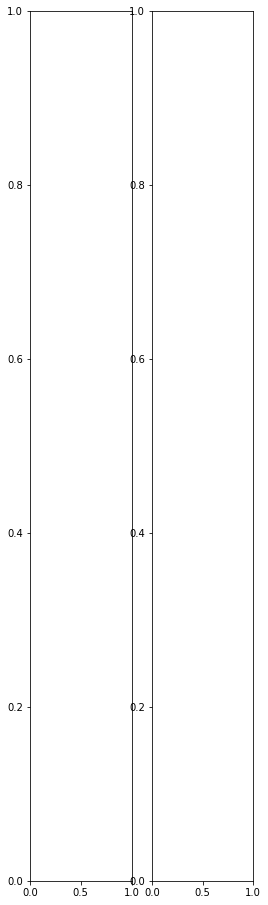

In [ ]:
plot_history(history)

## Improve the model
The baseline model seems to be the best one up to this point, so we are going to try to improve its performances. 




A straightforward modification is to move to GloVe embedding with size 300, as up to now the one with size 50 has been used. This new embedding is much heavier than the previous one, but is ensures better results. Considering these, all the following models will use this the embedding matrix built with this embedding size.

Then we are going to test what happens if we increase to 200 the number of LSTM hidden units, which previously were set to 100. 

Finally, as already pointed out, it is clear that the model starts to overfit, so we willl introduce a dropout layer and droput on the LSTM layer to check if it is goinf to reduce overfitting.

In [38]:
EMBEDDING_DIMENSION_BIGGER = 300
units_bigger = 200
dropout_percentage = 0.2

In [39]:
glove_emb_model_bigger = load_GloVe_embedding(EMBEDDING_DIMENSION_BIGGER)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [40]:
embedding_matrix_bigger = build_embedding_matrix(glove_emb_model_bigger, 
                                                EMBEDDING_DIMENSION_BIGGER,
                                                word_to_idx_train)
print(embedding_matrix_bigger.shape)

embedding_matrix_bigger = extend_embedding_matrix(glove_emb_model_bigger, 
                                                  embedding_matrix_bigger,
                                                  word_to_idx_val)
print(embedding_matrix_bigger.shape)

embedding_matrix_bigger = extend_embedding_matrix(glove_emb_model_bigger, 
                                                  embedding_matrix_bigger,
                                                  word_to_idx_test)
print(embedding_matrix_bigger.shape)

100%|██████████| 400318/400318 [00:01<00:00, 342715.70it/s]


(400319, 300)
(400475, 300)
(400571, 300)


In [42]:
def build_final_model(num_pos, 
                      embedding_matrix, 
                      name = 'final',
                      units = units_bigger, 
                      dropout_layer = True,
                      dropout_LSTM = True,
                      dropout_percentage = dropout_percentage):
  inputs = Input(shape=(None,), dtype="int32")

  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  if dropout_layer:
    m = Dropout(dropout_percentage)(m)

  if dropout_LSTM:
    m = Bidirectional(LSTM(units=units, return_sequences=True, dropout=dropout_percentage))(m)
  else:
    m = Bidirectional(LSTM(units=units, return_sequences=True))(m)

  m = Dense(num_pos, activation='softmax')(m)

  return Model(inputs, m, name=name)

In [45]:
final_models = {}
final_models_history = {}
final_models_f1_scores = {}

### Final model with more LSTM hidden units, a dropout layer and dropout on LSTM

In [56]:
final_models['units_bigger-dropout_layer-dropout_LSTM'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "units_bigger-dropout_layer-dropout_LSTM",
                                units = units_bigger,
                                dropout_layer = True,
                                dropout_LSTM = True,
                                dropout_percentage = dropout_percentage) 

In [57]:
final_models['units_bigger-dropout_layer-dropout_LSTM'].summary()

Model: "units_bigger-dropout_layer-dropout_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 300)         120171300 
                                                                 
 dropout_2 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 400)        801600    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, None, 46)          18446     
                                                                 
Total params: 120,991,346
Trainable params: 820,046
Non-trainable params: 120,171,300
_______

In [58]:
final_models['units_bigger-dropout_layer-dropout_LSTM'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])
final_models_history['units_bigger-dropout_layer-dropout_LSTM'] = final_models['units_bigger-dropout_layer-dropout_LSTM'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 15s 37ms/step - loss: 0.1244 - accuracy: 0.6614 - val_loss: 0.1861 - val_accuracy: 0.8196
Epoch 2/30
197/197 [==============================] - 4s 22ms/step - loss: 0.0527 - accuracy: 0.8421 - val_loss: 0.1384 - val_accuracy: 0.8629
Epoch 3/30
197/197 [==============================] - 4s 22ms/step - loss: 0.0416 - accuracy: 0.8715 - val_loss: 0.1184 - val_accuracy: 0.8820
Epoch 4/30
197/197 [==============================] - 5s 26ms/step - loss: 0.0346 - accuracy: 0.8919 - val_loss: 0.1075 - val_accuracy: 0.8903
Epoch 5/30
197/197 [==============================] - 6s 32ms/step - loss: 0.0295 - accuracy: 0.9076 - val_loss: 0.0973 - val_accuracy: 0.9008
Epoch 6/30
197/197 [==============================] - 5s 23ms/step - loss: 0.0253 - accuracy: 0.9196 - val_loss: 0.0902 - val_accuracy: 0.9060
Epoch 7/30
197/197 [==============================] - 5s 26ms/step - loss: 0.0217 - accuracy: 0.9323 - val_loss: 0.0874 - val_accuracy: 0.908

In [60]:
final_models["units_bigger-dropout_layer-dropout_LSTM"].save_weights('./units_bigger-dropout_layer-dropout_LSTM.h5')

In [61]:
final_models_f1_scores["units_bigger-dropout_layer-dropout_LSTM"] = compute_f1(final_models["units_bigger-dropout_layer-dropout_LSTM"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["units_bigger-dropout_layer-dropout_LSTM"]

41/41 [==============================] - 3s 9ms/step


0.8070168630965344

### Final model with smaller number of LSTM hidden units, dropout layer and dropout on LSTM

In [62]:
final_models['dropout_layer-dropout_LSTM'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "dropout_layer-dropout_LSTM",
                                units = units,
                                dropout_layer = True,
                                dropout_LSTM = True,
                                dropout_percentage = dropout_percentage) 

In [63]:
final_models['dropout_layer-dropout_LSTM'].summary()

Model: "dropout_layer-dropout_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 300)         120171300 
                                                                 
 dropout_3 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 200)        320800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, None, 46)          9246      
                                                                 
Total params: 120,501,346
Trainable params: 330,046
Non-trainable params: 120,171,300
____________________

In [64]:
final_models['dropout_layer-dropout_LSTM'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

final_models_history['dropout_layer-dropout_LSTM'] = final_models['dropout_layer-dropout_LSTM'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 15s 37ms/step - loss: 0.1496 - accuracy: 0.6069 - val_loss: 0.2307 - val_accuracy: 0.7864
Epoch 2/30
197/197 [==============================] - 5s 24ms/step - loss: 0.0634 - accuracy: 0.8180 - val_loss: 0.1594 - val_accuracy: 0.8478
Epoch 3/30
197/197 [==============================] - 5s 23ms/step - loss: 0.0484 - accuracy: 0.8545 - val_loss: 0.1347 - val_accuracy: 0.8693
Epoch 4/30
197/197 [==============================] - 5s 23ms/step - loss: 0.0408 - accuracy: 0.8780 - val_loss: 0.1182 - val_accuracy: 0.8834
Epoch 5/30
197/197 [==============================] - 5s 23ms/step - loss: 0.0358 - accuracy: 0.8903 - val_loss: 0.1082 - val_accuracy: 0.8905
Epoch 6/30
197/197 [==============================] - 5s 23ms/step - loss: 0.0317 - accuracy: 0.9027 - val_loss: 0.1001 - val_accuracy: 0.8969
Epoch 7/30
197/197 [==============================] - 5s 23ms/step - loss: 0.0285 - accuracy: 0.9120 - val_loss: 0.0946 - val_accuracy: 0.902

In [65]:
final_models["dropout_layer-dropout_LSTM"].save_weights('./dropout_layer-dropout_LSTM.h5')

In [66]:
final_models_f1_scores["dropout_layer-dropout_LSTM"] = compute_f1(final_models["dropout_layer-dropout_LSTM"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["dropout_layer-dropout_LSTM"]

41/41 [==============================] - 4s 8ms/step


0.8059982154811096

### Final model with more LSTM hidden units and a dropout layer

In [75]:
final_models['units_bigger-dropout_layer'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "units_bigger-dropout_layer",
                                units = units_bigger,
                                dropout_layer = True,
                                dropout_LSTM = False,
                                dropout_percentage = dropout_percentage) 

In [76]:
final_models['units_bigger-dropout_layer'].summary()

Model: "units_bigger-dropout_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 300)         120171300 
                                                                 
 dropout_5 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 400)        801600    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, None, 46)          18446     
                                                                 
Total params: 120,991,346
Trainable params: 820,046
Non-trainable params: 120,171,300
____________________

In [77]:
final_models['units_bigger-dropout_layer'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

final_models_history['units_bigger-dropout_layer'] = final_models['units_bigger-dropout_layer'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 15s 36ms/step - loss: 0.1182 - accuracy: 0.6836 - val_loss: 0.1769 - val_accuracy: 0.8302
Epoch 2/30
197/197 [==============================] - 4s 23ms/step - loss: 0.0473 - accuracy: 0.8599 - val_loss: 0.1315 - val_accuracy: 0.8703
Epoch 3/30
197/197 [==============================] - 4s 22ms/step - loss: 0.0360 - accuracy: 0.8910 - val_loss: 0.1124 - val_accuracy: 0.8877
Epoch 4/30
197/197 [==============================] - 4s 22ms/step - loss: 0.0290 - accuracy: 0.9105 - val_loss: 0.1022 - val_accuracy: 0.8951
Epoch 5/30
197/197 [==============================] - 4s 23ms/step - loss: 0.0239 - accuracy: 0.9262 - val_loss: 0.0929 - val_accuracy: 0.9039
Epoch 6/30
197/197 [==============================] - 5s 26ms/step - loss: 0.0196 - accuracy: 0.9413 - val_loss: 0.0867 - val_accuracy: 0.9093
Epoch 7/30
197/197 [==============================] - 6s 30ms/step - loss: 0.0161 - accuracy: 0.9520 - val_loss: 0.0839 - val_accuracy: 0.913

In [78]:
final_models["units_bigger-dropout_layer"].save_weights('./units_bigger-dropout_layer.h5')

In [79]:
final_models_f1_scores["units_bigger-dropout_layer"] = compute_f1(final_models["units_bigger-dropout_layer"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["units_bigger-dropout_layer"]

41/41 [==============================] - 4s 11ms/step


0.7976888497376766

### Final model with more LSTM hidden units and dropout on LSTM

In [80]:
final_models['units_bigger-dropout_LSTM'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "units_bigger-dropout_LSTM",
                                units = units_bigger,
                                dropout_layer = False,
                                dropout_LSTM = True,
                                dropout_percentage = dropout_percentage) 

In [81]:
final_models['units_bigger-dropout_LSTM'].summary()

Model: "units_bigger-dropout_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 300)         120171300 
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 400)        801600    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, None, 46)          18446     
                                                                 
Total params: 120,991,346
Trainable params: 820,046
Non-trainable params: 120,171,300
_________________________________________________________________


In [82]:
final_models['units_bigger-dropout_LSTM'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

final_models_history['units_bigger-dropout_LSTM'] = final_models['units_bigger-dropout_LSTM'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 15s 37ms/step - loss: 0.1178 - accuracy: 0.6837 - val_loss: 0.1764 - val_accuracy: 0.8311
Epoch 2/30
197/197 [==============================] - 6s 28ms/step - loss: 0.0462 - accuracy: 0.8646 - val_loss: 0.1310 - val_accuracy: 0.8702
Epoch 3/30
197/197 [==============================] - 6s 31ms/step - loss: 0.0347 - accuracy: 0.8938 - val_loss: 0.1131 - val_accuracy: 0.8867
Epoch 4/30
197/197 [==============================] - 5s 26ms/step - loss: 0.0279 - accuracy: 0.9146 - val_loss: 0.1027 - val_accuracy: 0.8936
Epoch 5/30
197/197 [==============================] - 6s 31ms/step - loss: 0.0229 - accuracy: 0.9296 - val_loss: 0.0947 - val_accuracy: 0.9033
Epoch 6/30
197/197 [==============================] - 6s 31ms/step - loss: 0.0184 - accuracy: 0.9449 - val_loss: 0.0875 - val_accuracy: 0.9085
Epoch 7/30
197/197 [==============================] - 5s 25ms/step - loss: 0.0151 - accuracy: 0.9553 - val_loss: 0.0861 - val_accuracy: 0.911

In [83]:
final_models["units_bigger-dropout_LSTM"].save_weights('./units_bigger-dropout_LSTM.h5')

In [84]:
final_models_f1_scores["units_bigger-dropout_LSTM"] = compute_f1(final_models["units_bigger-dropout_LSTM"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["units_bigger-dropout_LSTM"]

41/41 [==============================] - 4s 12ms/step


0.8010435556741525

### Final model with only bigger embedding size

In [85]:
final_models['bigger_embedding_size'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "bigger_embedding_size",
                                units = units,
                                dropout_layer = False,
                                dropout_LSTM = False) 

In [86]:
final_models['bigger_embedding_size'].summary()

Model: "bigger_embedding_size"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 300)         120171300 
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 200)        320800    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, None, 46)          9246      
                                                                 
Total params: 120,501,346
Trainable params: 330,046
Non-trainable params: 120,171,300
_________________________________________________________________


In [87]:
final_models['bigger_embedding_size'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

final_models_history['bigger_embedding_size'] = final_models['bigger_embedding_size'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 15s 38ms/step - loss: 0.1387 - accuracy: 0.6435 - val_loss: 0.2126 - val_accuracy: 0.8074
Epoch 2/30
197/197 [==============================] - 5s 24ms/step - loss: 0.0512 - accuracy: 0.8584 - val_loss: 0.1457 - val_accuracy: 0.8627
Epoch 3/30
197/197 [==============================] - 5s 24ms/step - loss: 0.0360 - accuracy: 0.8992 - val_loss: 0.1228 - val_accuracy: 0.8838
Epoch 4/30
197/197 [==============================] - 5s 24ms/step - loss: 0.0282 - accuracy: 0.9201 - val_loss: 0.1081 - val_accuracy: 0.8932
Epoch 5/30
197/197 [==============================] - 5s 24ms/step - loss: 0.0227 - accuracy: 0.9354 - val_loss: 0.0991 - val_accuracy: 0.9013
Epoch 6/30
197/197 [==============================] - 5s 24ms/step - loss: 0.0183 - accuracy: 0.9495 - val_loss: 0.0916 - val_accuracy: 0.9074
Epoch 7/30
197/197 [==============================] - 5s 24ms/step - loss: 0.0149 - accuracy: 0.9608 - val_loss: 0.0891 - val_accuracy: 0.909

In [88]:
final_models["bigger_embedding_size"].save_weights('./bigger_embedding_size.h5')

In [89]:
final_models_f1_scores["bigger_embedding_size"] = compute_f1(final_models["bigger_embedding_size"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["bigger_embedding_size"]

41/41 [==============================] - 3s 8ms/step


0.772912677062819

### Check histories

In [90]:
plot_history(final_models_history)

NameError: ignored

## Evaluation on test set

In [ ]:
f1_scores_test = {}

In [ ]:
f1_scores_test["final"] = compute_f1(models["final"],x_st["test"],y_cat["test"],punctuation_enc)
f1_scores_test["final"]

21/21 [==============================] - 0s 8ms/step


0.8515409177582665